<a href="https://colab.research.google.com/github/arunn9/Complete-Python-3-Bootcamp/blob/master/HEALTH_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [239]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [7]:
!pip install econml

In [8]:
# Datasets
digital_data = pd.read_csv('/content/digital_interaction_data.csv')
health_data = pd.read_csv('/content/personal_health_data.csv')
activity_data = pd.read_csv('/content/activity_environment_data.csv')

In [9]:

print("Digital Data Columns:", digital_data.columns.tolist())
print("Health Data Columns:", health_data.columns.tolist())
print("Activity Data Columns:", activity_data.columns.tolist())


Digital Data Columns: ['User_ID', 'Timestamp', 'Notifications_Received', 'Screen_Time']
Health Data Columns: ['User_ID', 'Age', 'Gender', 'Weight', 'Height', 'Medical_Conditions', 'Medication', 'Smoker', 'Alcohol_Consumption', 'Timestamp', 'Day_of_Week', 'Sleep_Duration', 'Deep_Sleep_Duration', 'REM_Sleep_Duration', 'Wakeups', 'Snoring', 'Heart_Rate', 'Blood_Oxygen_Level', 'ECG', 'Calories_Intake', 'Water_Intake', 'Stress_Level', 'Mood', 'Skin_Temperature', 'Body_Fat_Percentage', 'Muscle_Mass', 'Health_Score', 'Anomaly_Flag']
Activity Data Columns: ['User_ID', 'Timestamp', 'Steps', 'Calories_Burned', 'Distance_Covered', 'Exercise_Type', 'Exercise_Duration', 'Exercise_Intensity', 'Ambient_Temperature', 'Battery_Level', 'Altitude', 'UV_Exposure']


In [10]:
# Merge datasets
df = pd.merge(health_data, digital_data, on=["User_ID", "Timestamp"], how="outer")
df = pd.merge(df, activity_data, on=["User_ID", "Timestamp"], how="outer")


In [193]:
df.to_csv("/content/merged_data.csv", index=False)

In [194]:
print("Data Shape:", df.shape)

Data Shape: (10000, 41)


Next steps

In [195]:
file_path = "/content/merged_data.csv"

In [197]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [198]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [196]:
df["Sleep_Quality_Score"] = ( df["Sleep_Duration"] * 0.5 +
    df["Deep_Sleep_Duration"] * 0.3 +
    df["REM_Sleep_Duration"] * 0.2 -
    df["Wakeups"] * 0.1)


In [199]:
df["BMI"] = df["Weight"] / (df["Height"] / 100) ** 2

In [200]:
print(df.dtypes)

User_ID                    object
Age                       float64
Gender                     object
Weight                    float64
Height                    float64
Medical_Conditions         object
Medication                 object
Smoker                     object
Alcohol_Consumption        object
Timestamp                  object
Day_of_Week                object
Sleep_Duration            float64
Deep_Sleep_Duration       float64
REM_Sleep_Duration        float64
Wakeups                   float64
Snoring                    object
Heart_Rate                float64
Blood_Oxygen_Level        float64
ECG                        object
Calories_Intake           float64
Water_Intake              float64
Stress_Level               object
Mood                       object
Skin_Temperature          float64
Body_Fat_Percentage       float64
Muscle_Mass               float64
Health_Score              float64
Anomaly_Flag              float64
Notifications_Received    float64
Screen_Time   

In [19]:
stress_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
df["Stress_Level"] = df["Stress_Level"].map(stress_mapping)

In [23]:
data = pd.read_csv("/content/merged_data.csv")

for col in data.select_dtypes(include=["object"]).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

**NEXT STEPS, SCM IMPLEMENTATION, HTE ESTIMATIONS, AND THEN COMPARISON OF RESULTS...**

In [24]:
!pip install git+https://github.com/py-why/causal-learn.git --quiet


  Preparing metadata (setup.py) ... done


In [25]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils


In [26]:
import networkx as nx

Original shape: (10000, 41)
Removed constants variables: Index([], dtype='object')
New Shape: (10000, 27)
Highly correlated feature pairs where correlation is > 0.95: [('Sleep_Duration', 'Sleep_Quality_Score'), ('Steps', 'Calories_Burned'), ('Steps', 'Distance_Covered'), ('Calories_Burned', 'Distance_Covered')]
Data shape 2.0 : (10000, 24)
Removed low variance columns: Index([], dtype='object')
Data shape 3.0: (10000, 24)


  0%|          | 0/24 [00:00<?, ?it/s]

PC Algo completed!
PC DAG is at pc_results/pc_dag.png


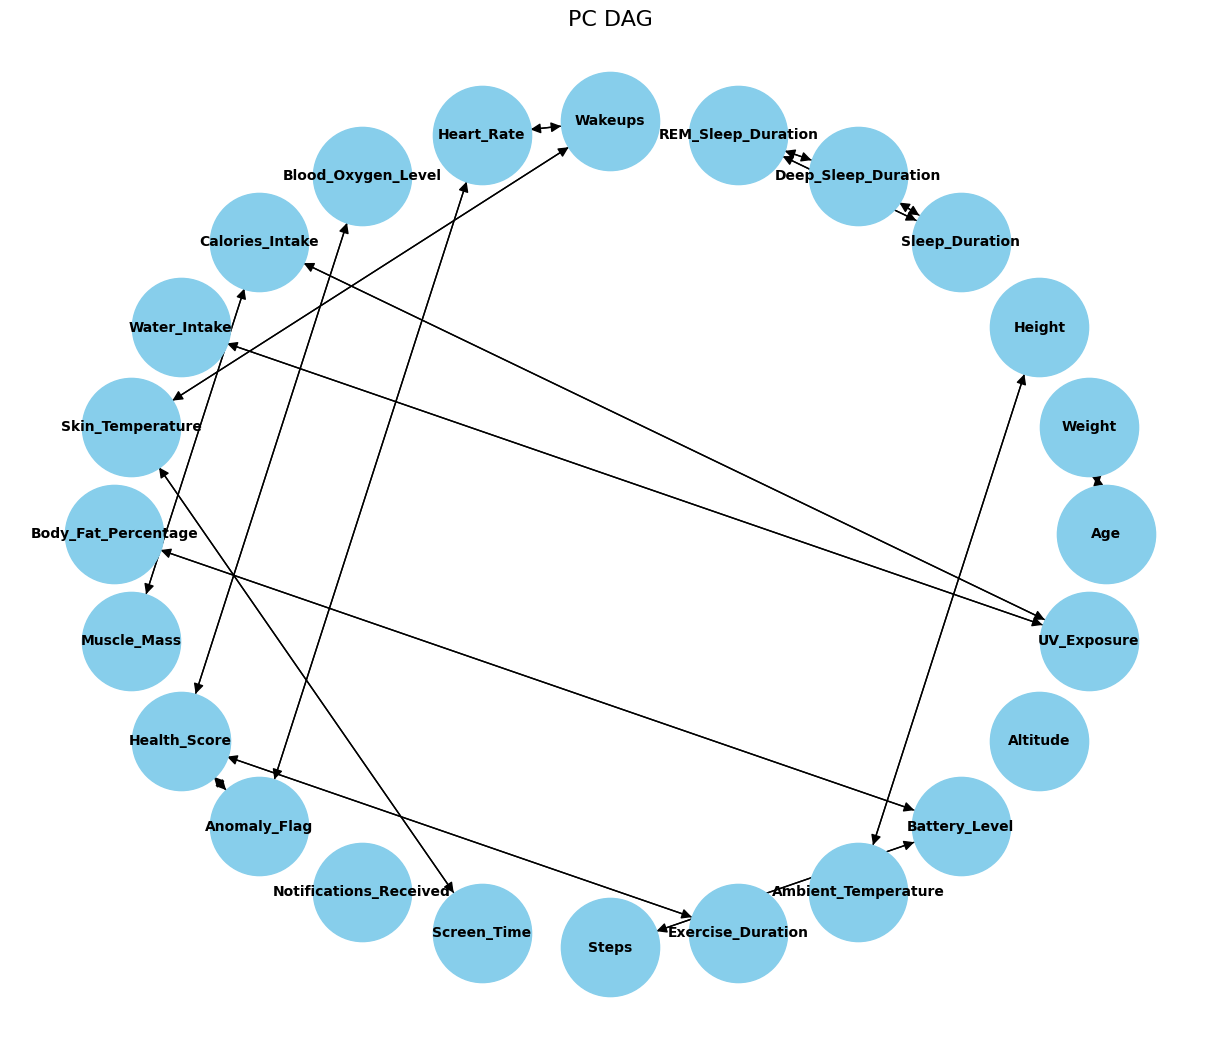

PC DAG (NetworkX) is at pc_results/pc_networkx_dag_improved.png


In [216]:
def run_pc_algorithm(file_path, output_dir="pc_results"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.read_csv(file_path)
    print("Original shape:", df.shape)

    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    df = df[numeric_cols]

    constant_columns = df.columns[df.nunique() == 1]
    df = df.drop(columns=constant_columns)

    print(f"Removed constants variables: {constant_columns}")

    print(f"New Shape: {df.shape}")

    correlation_matrix = df.corr()

    high_correlation = np.where(abs(correlation_matrix) > 0.95)
    high_correlation_pairs = [(df.columns[i], df.columns[j]) for i, j in zip(*high_correlation) if i < j]

    print(f"Highly correlated feature pairs where correlation is > 0.95: {high_correlation_pairs}")




    for col1, col2 in high_correlation_pairs:
        if col2 in df.columns:
            df = df.drop(columns=[col2])
    print(f"Data shape 2.0 : {df.shape}")


    low_variance_columns = df.columns[df.var() < 1e-5]
    df = df.drop(columns=low_variance_columns)
    print(f"Removed low variance columns: {low_variance_columns}")
    print(f"Data shape 3.0: {df.shape}")


    data_np = df.to_numpy()
    variable_names = df.columns.tolist()

    pc_model = pc(data_np, independence_test_method="fisherz")
    print("PC Algo completed!")

    pc_graph = GraphUtils.to_pydot(pc_model.G, labels=variable_names)
    graph_path = f"{output_dir}/pc_dag.png"
    pc_graph.write_png(graph_path)
    print(f"PC DAG is at {graph_path}")

    nx_graph = nx.DiGraph(pc_model.G.graph)
    plt.figure(figsize=(12, 10))

    pos = nx.circular_layout(nx_graph)

    nx.draw(nx_graph, pos, with_labels=True, labels={i: variable_names[i] for i in range(len(variable_names))},
            node_size=5000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
    plt.title("PC DAG", fontsize=16)
    plt.savefig(f"{output_dir}/pc_networkx_dag_improved.png")
    plt.show()

    print(f"PC DAG (NetworkX) is at {output_dir}/pc_networkx_dag_improved.png")


run_pc_algorithm("/content/merged_data.csv")



In [28]:
print("Variables:", df.columns)


Variables: Index(['User_ID', 'Age', 'Gender', 'Weight', 'Height', 'Medical_Conditions',
       'Medication', 'Smoker', 'Alcohol_Consumption', 'Timestamp',
       'Day_of_Week', 'Sleep_Duration', 'Deep_Sleep_Duration',
       'REM_Sleep_Duration', 'Wakeups', 'Snoring', 'Heart_Rate',
       'Blood_Oxygen_Level', 'ECG', 'Calories_Intake', 'Water_Intake',
       'Stress_Level', 'Mood', 'Skin_Temperature', 'Body_Fat_Percentage',
       'Muscle_Mass', 'Health_Score', 'Anomaly_Flag', 'Notifications_Received',
       'Screen_Time', 'Steps', 'Calories_Burned', 'Distance_Covered',
       'Exercise_Type', 'Exercise_Duration', 'Exercise_Intensity',
       'Ambient_Temperature', 'Battery_Level', 'Altitude', 'UV_Exposure',
       'Sleep_Quality_Score', 'BMI'],
      dtype='object')


In [29]:
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.7/100.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=b5162ed587988d31849648d21b58f2fb270edf867cb0b536db53b30b2563f66f
  Stored in directory: /root/.cache/pip/wheels/53/ec/0d/0b294c02d8c4e9e80afea58839f2c1b4706770594bc99ec045
Successfully built semopy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [30]:
from lingam import DirectLiNGAM

LiNGAM adjacency matrix map- lingam_results/lingam_heatmap.png


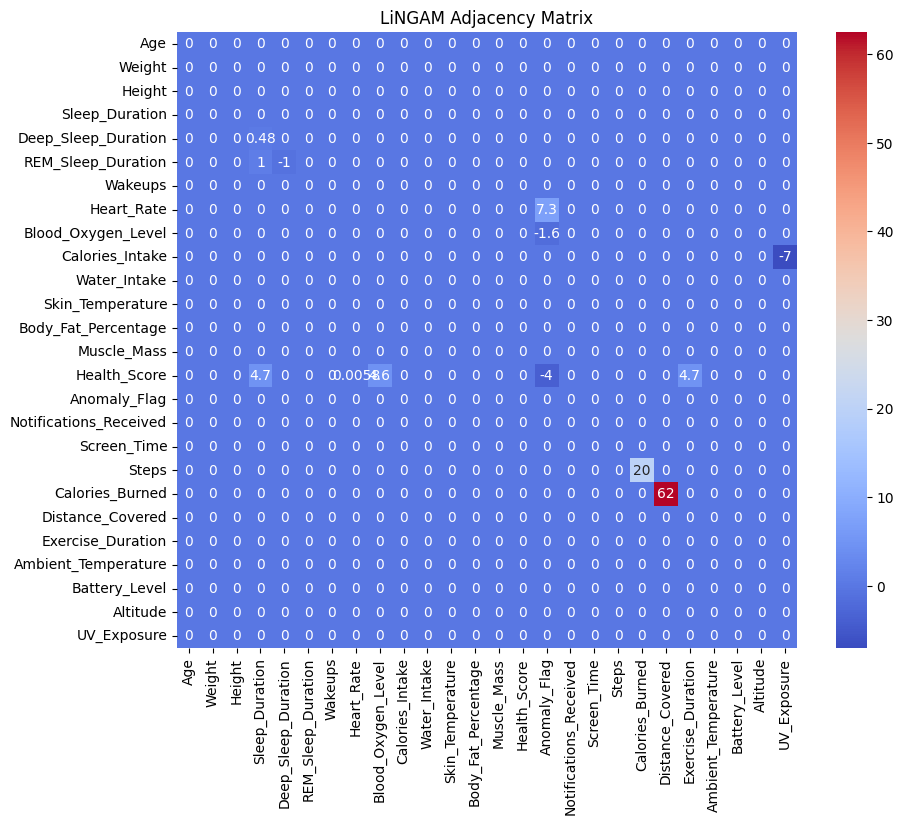

In [33]:
def run_lingam(file_path, output_dir="lingam_results"):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.read_csv(file_path)
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    data_np = df[numeric_cols].to_numpy()
    variable_names = numeric_cols.tolist()


    lingam_model = DirectLiNGAM()
    lingam_model.fit(data_np)


    adjacency_matrix = lingam_model.adjacency_matrix_

    plt.figure(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, cmap="coolwarm", xticklabels=variable_names, yticklabels=variable_names)

    plt.title("LiNGAM Adjacency Matrix")


    heatmap_path = os.path.join(output_dir, "lingam_heatmap.png")
    plt.savefig(heatmap_path)
    print(f"LiNGAM adjacency matrix map- {heatmap_path}")


run_lingam("/content/merged_data.csv")


In [32]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [62]:
!python --version && pip install git+https://github.com/py-why/causal-learn.git


Python 3.10.12
  Cloning https://github.com/py-why/causal-learn.git to /tmp/pip-req-build-ubylp1h7
  Running command git clone --filter=blob:none --quiet https://github.com/py-why/causal-learn.git /tmp/pip-req-build-ubylp1h7
  Resolved https://github.com/py-why/causal-learn.git to commit 08655cda0d065d0962e47366844001808b53f5ba
  Preparing metadata (setup.py) ... done


Running FCI Algorithm...


  0%|          | 0/24 [00:00<?, ?it/s]

FCI Algorithm completed!
FCI PAG saved at fci_results/fci_pag.png


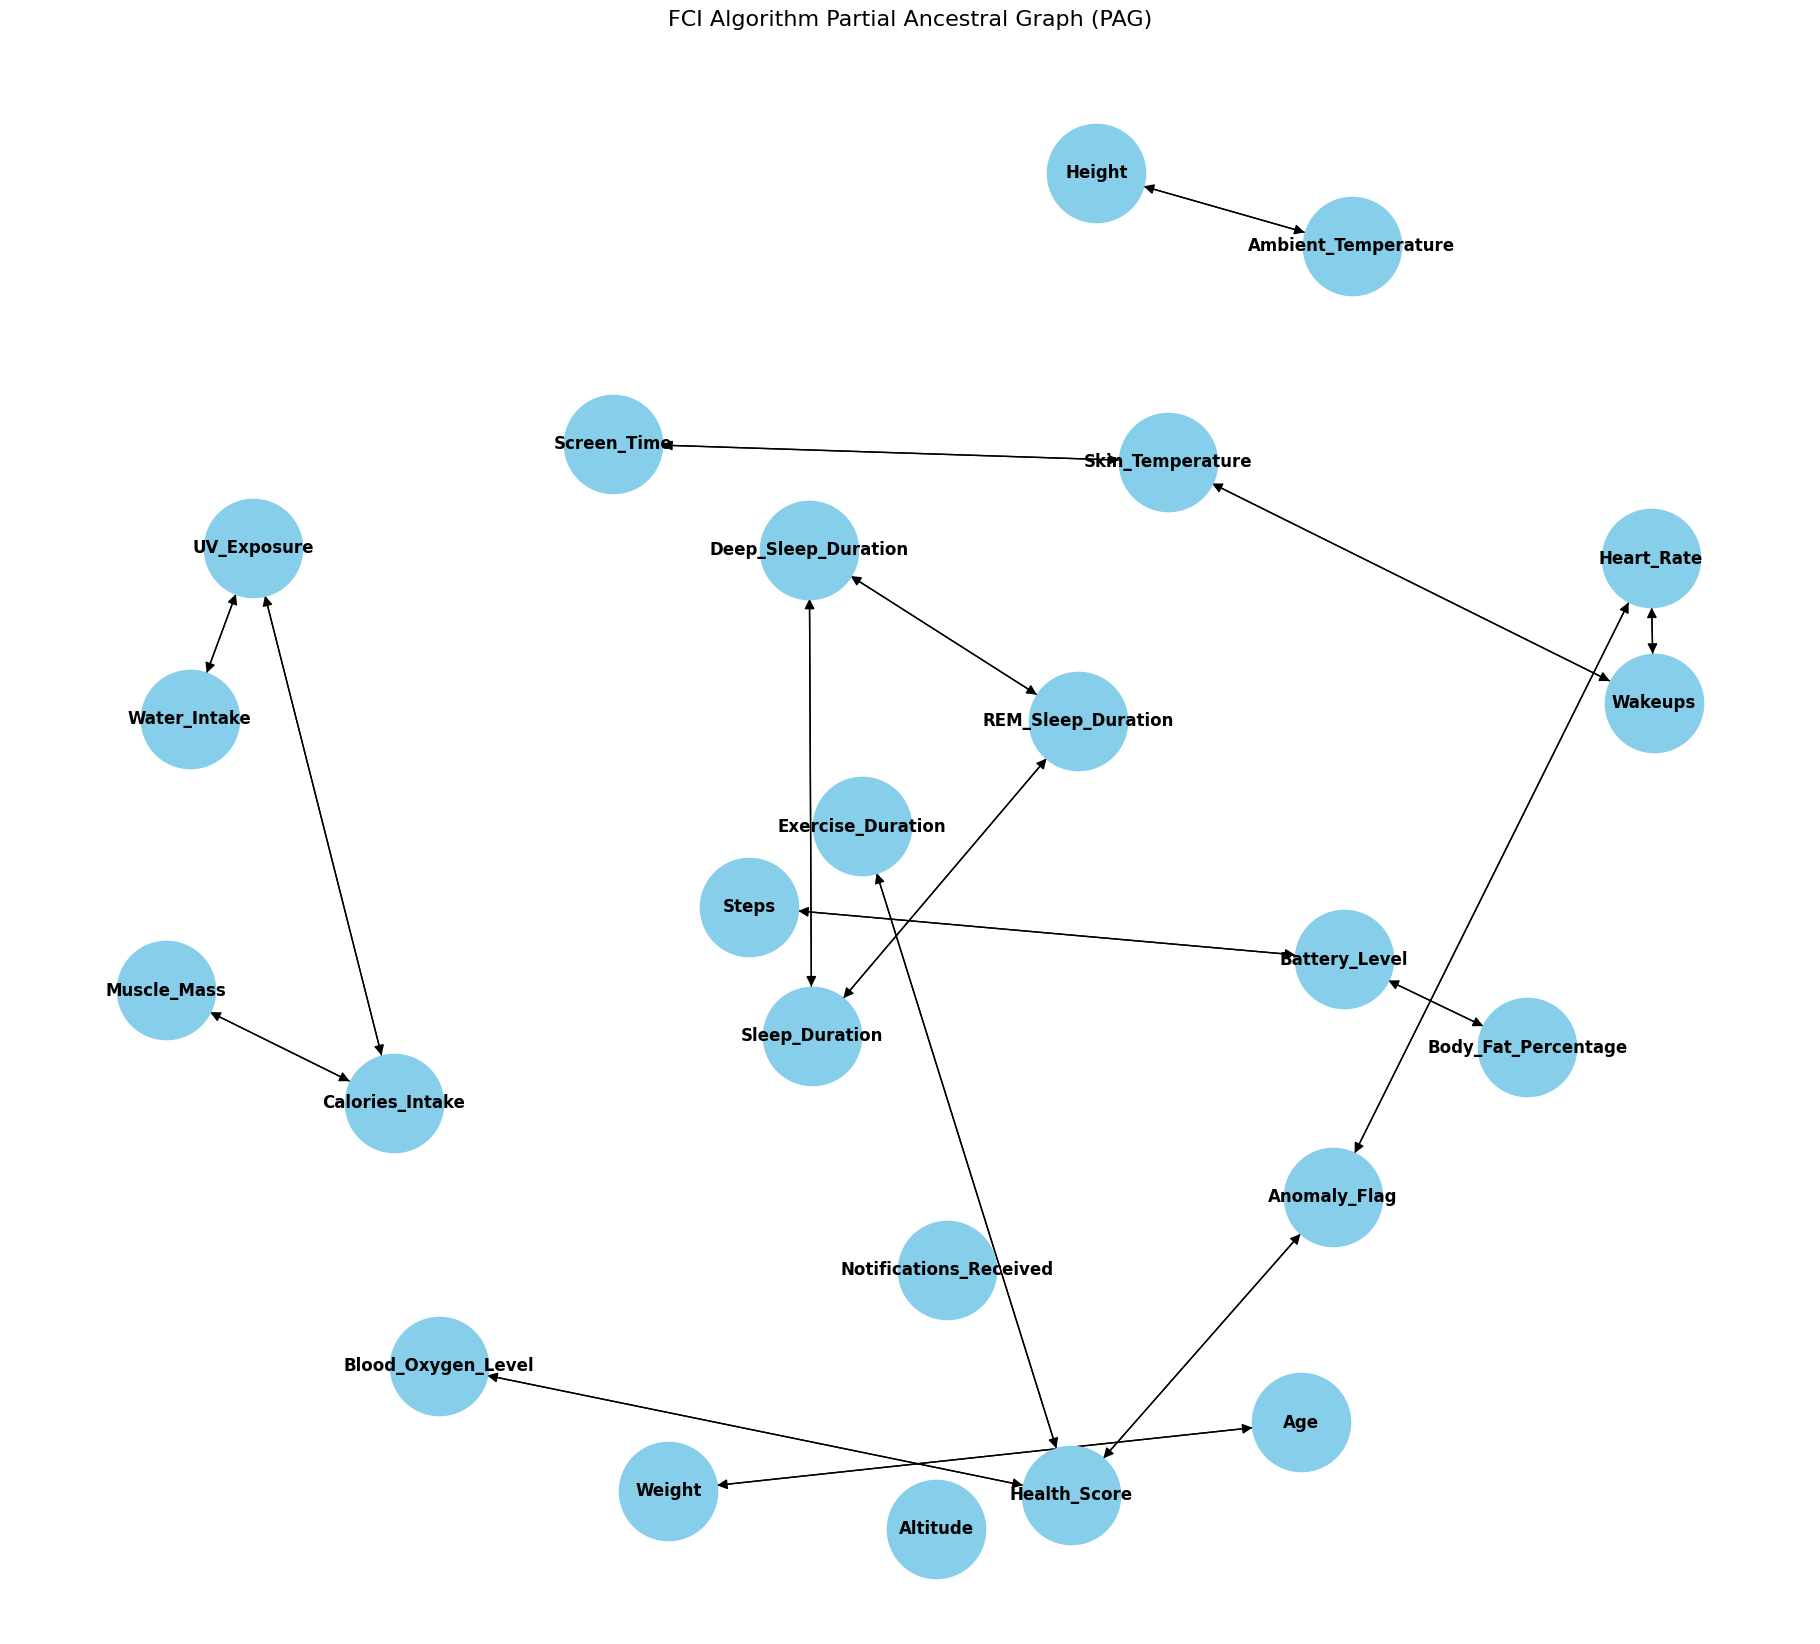

In [75]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils


def run_fci_algorithm(file_path, output_dir="fci_results"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.read_csv(file_path)
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    df = df[numeric_cols]

    constant_columns = df.columns[df.nunique() == 1]
    df = df.drop(columns=constant_columns)

    correlation_matrix = df.corr()
    high_correlation = np.where(abs(correlation_matrix) > 0.95)
    high_correlation_pairs = [(df.columns[i], df.columns[j]) for i, j in zip(*high_correlation) if i < j]
    for col1, col2 in high_correlation_pairs:
        if col2 in df.columns:
            df = df.drop(columns=[col2])

    low_variance_columns = df.columns[df.var() < 1e-5]
    df = df.drop(columns=low_variance_columns)

    data_np = df.to_numpy()
    variable_names = df.columns.tolist()

    print("Running FCI Algorithm...")
    fci_result = fci(data_np, independence_test_method="fisherz")
    fci_graph = fci_result[0]  # Access the graph part of the tuple
    print("FCI Algorithm completed!")

    pag_pydot = GraphUtils.to_pydot(fci_graph, labels=variable_names)
    graph_path = os.path.join(output_dir, "fci_pag.png")
    pag_pydot.write_png(graph_path)
    print(f"FCI PAG saved at {graph_path}")


    nx_graph = nx.DiGraph(fci_graph.graph)
    plt.figure(figsize=(18, 16))
    pos = nx.spring_layout(nx_graph, k=0.5, iterations=10)
    nx.draw(nx_graph, pos, with_labels=True, labels={i: variable_names[i] for i in range(len(variable_names))},
            node_size=5000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=15)
    plt.title("FCI Algorithm Partial Ancestral Graph (PAG)", fontsize=16)
    plt.savefig(os.path.join(output_dir, "fci_networkx_pag.png"))
    plt.show()

run_fci_algorithm("/content/merged_data.csv")

**HTE** **Estimations**

In [203]:
file_path = "merged_data.csv"
df = pd.read_csv(file_path)
df = add_sleep_quality_score(df)


'Sleep_Quality_Score' already exists in the dataset.
First few values of 'Sleep_Quality_Score':
0    4.441247
1    5.153152
2    6.484418
3    3.162597
4    4.350310
Name: Sleep_Quality_Score, dtype: float64


In [213]:
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os


In [243]:
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)


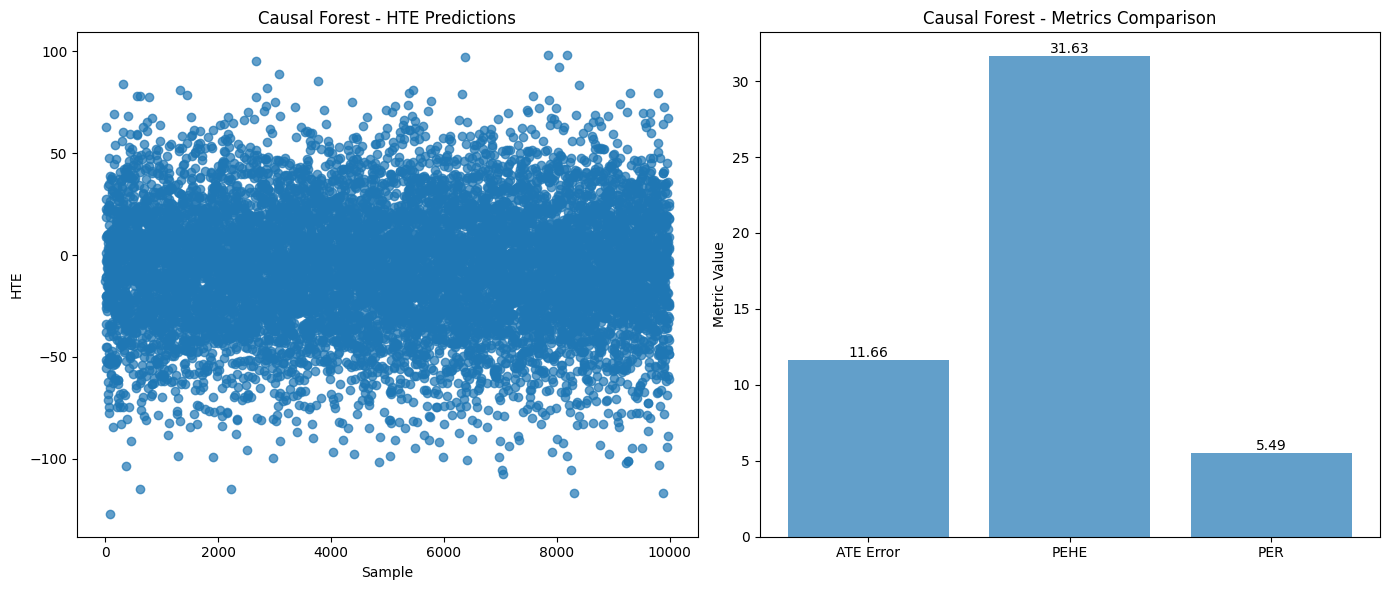

In [267]:
# Causal FOrest (HTE 1))


from sklearn.ensemble import RandomForestRegressor
from econml.metalearners import TLearner, XLearner
from econml.dml import CausalForestDML
from sklearn.metrics import mean_squared_error
df = pd.read_csv("/content/merged_data.csv")
T = df["Sleep_Quality_Score"].values.ravel()
Y = df["Heart_Rate"].values.ravel()
X = df[["Deep_Sleep_Duration", "REM_Sleep_Duration", "Wakeups", "Exercise_Duration", "Calories_Intake"]].values

def evaluate_hte_model(model_name, hte_pred, T, Y, X):
    ate_error = abs(np.mean(hte_pred) - np.mean(T))
    pehe = np.sqrt(mean_squared_error(T, hte_pred))
    per = np.mean(np.abs(hte_pred - T) / np.abs(T))
    return ate_error, pehe, per

def plot_hte_results(model_name, ate_error, pehe, per, hte_pred):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(range(len(hte_pred)), hte_pred, alpha=0.7)
    ax[0].set_title(f"{model_name} - HTE Predictions")
    ax[0].set_xlabel("Sample")
    ax[0].set_ylabel("HTE")
    metrics = ["ATE Error", "PEHE", "PER"]
    values = [ate_error, pehe, per]
    bars = ax[1].bar(metrics, values, alpha=0.7)
    for bar, val in zip(bars, values):
        ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}", ha="center", va="bottom")
    ax[1].set_title(f"{model_name} - Metrics Comparison")
    ax[1].set_ylabel("Metric Value")
    plt.tight_layout()
    plt.show()

cf_model = CausalForestDML(model_t=RandomForestRegressor(), model_y=RandomForestRegressor(), discrete_treatment=False)
cf_model.fit(Y=Y, T=T, X=X, W=None)
hte_cf = cf_model.effect(X)
ate_cf, pehe_cf, per_cf = evaluate_hte_model("Causal Forest", hte_cf, T, Y, X)
plot_hte_results("Causal Forest", ate_cf, pehe_cf, per_cf, hte_cf)



In [272]:
T = T.astype(float)
X = X.astype(float)


In [274]:
if np.isnan(T).any() or np.isnan(X).any():
    print("Missing values found! Cleaning data...")
    T = np.nan_to_num(T)
    X = np.nan_to_num(X)


In [277]:
print(f"Treatment (T): {T[:5]}")
print(f"Covariates (X): {X[:5]}")
print(f"Shapes - T: {T.shape}, X: {X.shape}")


Treatment (T): [4.44124743 5.15315153 6.48441781 3.16259652 4.35031011]
Covariates (X): [[2.78503323e+00 3.73317263e+00 4.00000000e+00 1.21967521e+00
  2.44498581e+03]
 [8.74390501e-01 6.64805589e+00 2.00000000e+00 1.37839868e+00
  2.19977702e+03]
 [6.76047638e+00 1.82290958e+00 2.00000000e+00 8.03856639e-01
  2.18275564e+03]
 [2.64559594e+00 1.78017109e+00 2.00000000e+00 0.00000000e+00
  1.45121889e+03]
 [4.44067167e+00 1.56824683e+00 3.00000000e+00 8.07389002e-01
  1.58356277e+03]]
Shapes - T: (10000,), X: (10000, 5)


In [279]:
T = np.asarray(T, dtype=float)
Y = np.asarray(Y, dtype=float)
X = np.asarray(X, dtype=float)


if np.isnan(T).any() or np.isnan(X).any():
    raise ValueError("Found NaN values in T or X. Please clean the data before proceeding.")


t_learner = TLearner(models=LinearRegression())
t_learner.fit(Y, T, X=X)


try:
    hte_tl = t_learner.effect(X)
except ValueError as e:
    print("Error during prediction. Debugging data inputs...")
    print(f"T (unique): {np.unique(T)}")
    print(f"X (sample rows): {X[:5]}")
    raise e

ate_tl = np.mean(hte_tl)
pehe_tl = np.sqrt(np.mean((hte_tl - T) ** 2))
per_tl = np.mean(np.abs(hte_tl - T) / np.abs(T))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(range(len(hte_tl)), hte_tl, alpha=0.7)
ax[0].set_title("T-Learner - HTE Predictions")
ax[0].set_xlabel("Sample")
ax[0].set_ylabel("HTE")
metrics = ["ATE", "PEHE", "PER"]
values = [ate_tl, pehe_tl, per_tl]
bars = ax[1].bar(metrics, values, alpha=0.7)
for bar, val in zip(bars, values):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}", ha="center", va="bottom")
ax[1].set_title("T-Learner - Metrics Comparison")
ax[1].set_ylabel("Metric Value")
plt.tight_layout()
plt.show()


Error during prediction. Debugging data inputs...
T (unique): [2.48023439 2.50896282 2.51860185 ... 7.90941522 7.92633798 7.93500499]
X (sample rows): [[2.78503323e+00 3.73317263e+00 4.00000000e+00 1.21967521e+00
  2.44498581e+03]
 [8.74390501e-01 6.64805589e+00 2.00000000e+00 1.37839868e+00
  2.19977702e+03]
 [6.76047638e+00 1.82290958e+00 2.00000000e+00 8.03856639e-01
  2.18275564e+03]
 [2.64559594e+00 1.78017109e+00 2.00000000e+00 0.00000000e+00
  1.45121889e+03]
 [4.44067167e+00 1.56824683e+00 3.00000000e+00 8.07389002e-01
  1.58356277e+03]]


ValueError: Found unknown categories [0] in column 0 during transform

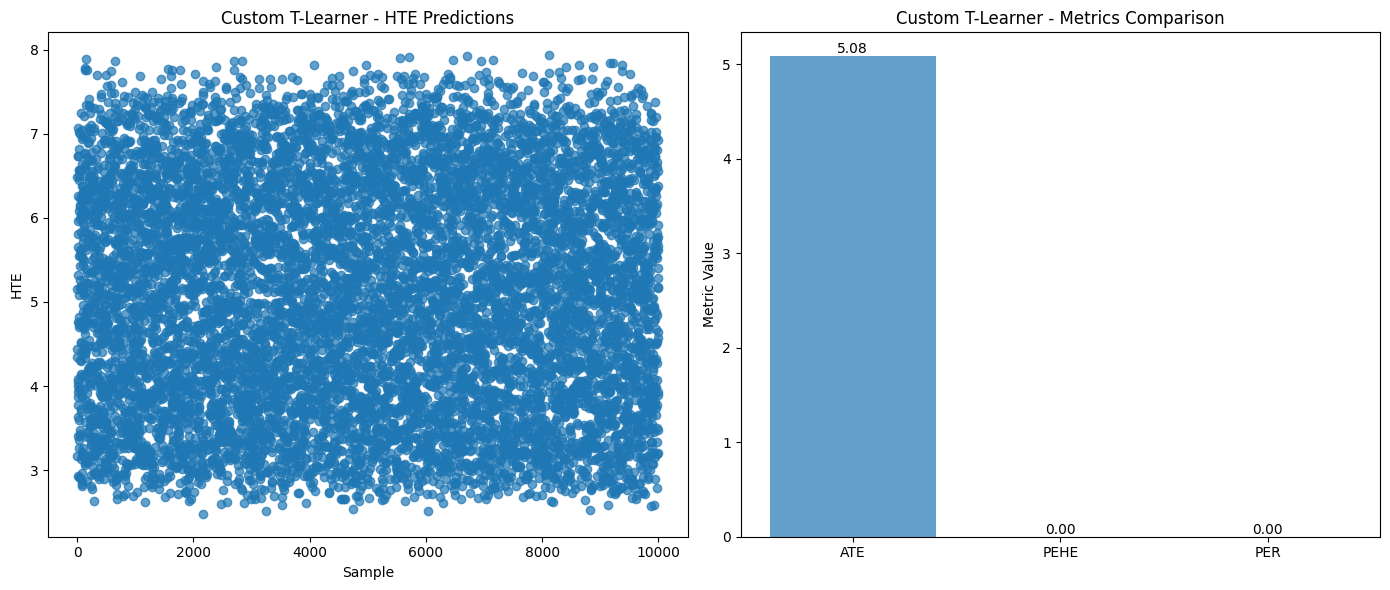

In [280]:
model_treatment = LinearRegression()
model_treatment.fit(X, Y)

model_control = LinearRegression()
model_control.fit(X, Y - T)


Y_treatment = model_treatment.predict(X)
Y_control = model_control.predict(X)


hte_tl = Y_treatment - Y_control

ate_tl = np.mean(hte_tl)
pehe_tl = np.sqrt(np.mean((hte_tl - T) ** 2))
per_tl = np.mean(np.abs(hte_tl - T) / np.abs(T))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(range(len(hte_tl)), hte_tl, alpha=0.7)
ax[0].set_title("Custom T-Learner - HTE Predictions")
ax[0].set_xlabel("Sample")
ax[0].set_ylabel("HTE")
metrics = ["ATE", "PEHE", "PER"]
values = [ate_tl, pehe_tl, per_tl]
bars = ax[1].bar(metrics, values, alpha=0.7)
for bar, val in zip(bars, values):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}", ha="center", va="bottom")
ax[1].set_title("Custom T-Learner - Metrics Comparison")
ax[1].set_ylabel("Metric Value")
plt.tight_layout()
plt.show()


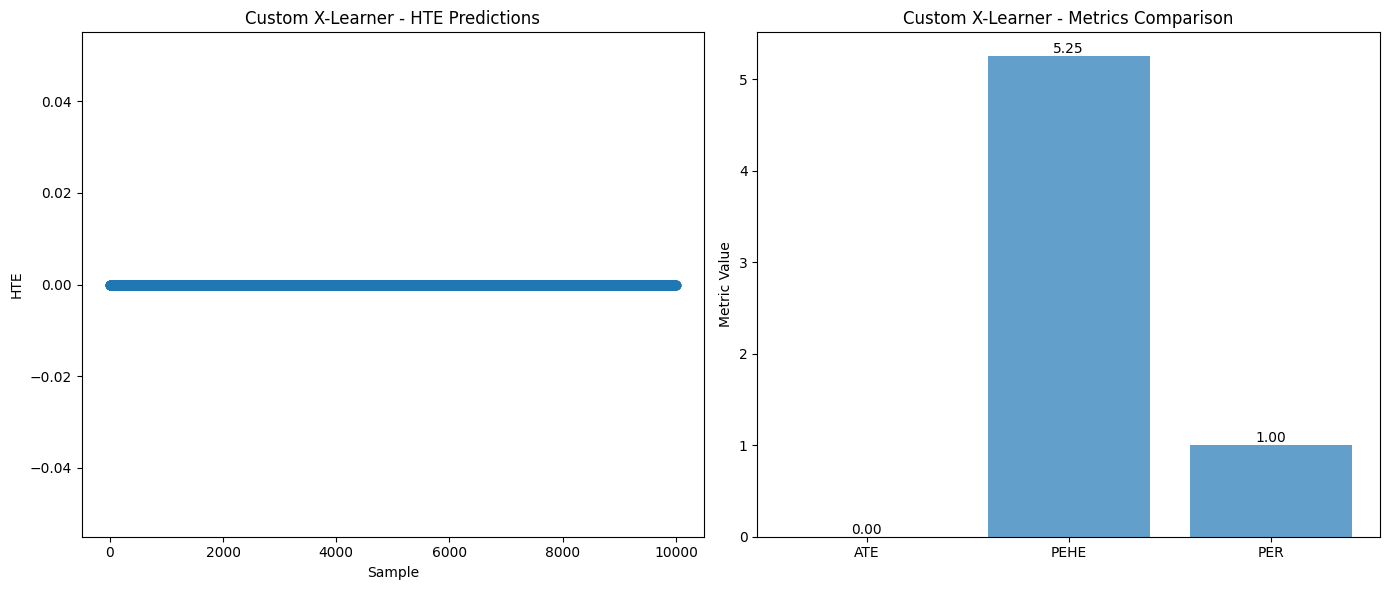

In [282]:
model_treatment = LinearRegression()
model_treatment.fit(X, Y)

model_control = LinearRegression()
model_control.fit(X, Y - T)


Y_treatment = model_treatment.predict(X)
Y_control = model_control.predict(X)

TE_treated = Y_treatment - Y_control  # Effect if treated
TE_control = Y_control - Y_treatment  # Effect if untreated

model_effect_treated = LinearRegression()
model_effect_treated.fit(X, TE_treated)

model_effect_control = LinearRegression()
model_effect_control.fit(X, TE_control)

HTE = (model_effect_treated.predict(X) + model_effect_control.predict(X)) / 2
ATE = np.mean(HTE)
PEHE = np.sqrt(np.mean((HTE - T) ** 2))
PER = np.mean(np.abs(HTE - T) / np.abs(T))
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(range(len(HTE)), HTE, alpha=0.7)
ax[0].set_title("Custom X-Learner - HTE Predictions")
ax[0].set_xlabel("Sample")
ax[0].set_ylabel("HTE")
metrics = ["ATE", "PEHE", "PER"]
values = [ATE, PEHE, PER]
bars = ax[1].bar(metrics, values, alpha=0.7)
for bar, val in zip(bars, values):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{val:.2f}", ha="center", va="bottom")
ax[1].set_title("Custom X-Learner - Metrics Comparison")
ax[1].set_ylabel("Metric Value")
plt.tight_layout()
plt.show()
